In [6]:
#### Q.1

In [5]:
import pandas as pd
import numpy as np

# Load the distance matrix from the Excel file
file_path = "BUS DATA.xlsx"  # Update with the correct path if needed
distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)

# Convert the DataFrame to a NumPy array for processing
distance_matrix = distance_df.to_numpy()

def nearest_neighbor(distance_matrix):
    """Solves TSP using the Nearest Neighbor Heuristic."""
    num_nodes = len(distance_matrix)
    visited = [False] * num_nodes
    route = [0]  # Start at node 0 (first house)
    visited[0] = True
    total_distance = 0

    for _ in range(num_nodes - 1):
        last = route[-1]
        nearest = None
        nearest_distance = float('inf')

        for i in range(num_nodes):
            if not visited[i] and 0 < distance_matrix[last][i] < nearest_distance:
                nearest = i
                nearest_distance = distance_matrix[last][i]

        if nearest is not None:
            route.append(nearest)
            visited[nearest] = True
            total_distance += nearest_distance

    # Return to start
    route.append(0)
    total_distance += distance_matrix[route[-2]][0]

    return route, total_distance

# Running Nearest Neighbor Algorithm
nn_route, nn_distance = nearest_neighbor(distance_matrix)

# Displaying results
print("\n--- Nearest Neighbor Algorithm Solution ---")
print(f"Optimal Route Found: {nn_route}")
print(f"Total Distance Traveled: {nn_distance}")



--- Nearest Neighbor Algorithm Solution ---
Optimal Route Found: [0, 5, 4, 8, 9, 2, 1, 7, 3, 6, 0]
Total Distance Traveled: 45


In [ ]:
#### Q. 2

In [9]:
import itertools
import time
import pandas as pd
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

### 1. Nearest Neighbor Algorithm ###
def nearest_neighbor(distance_matrix):
    """Solves TSP using the Nearest Neighbor Heuristic."""
    num_nodes = len(distance_matrix)
    visited = [False] * num_nodes
    route = [0]  # Start at node 0
    visited[0] = True
    total_distance = 0

    for _ in range(num_nodes - 1):
        last = route[-1]
        nearest = None
        nearest_distance = float('inf')

        for i in range(num_nodes):
            if not visited[i] and 0 < distance_matrix[last][i] < nearest_distance:
                nearest = i
                nearest_distance = distance_matrix[last][i]

        if nearest is not None:
            route.append(nearest)
            visited[nearest] = True
            total_distance += nearest_distance

    # Return to start
    route.append(0)
    total_distance += distance_matrix[route[-2]][0]

    return route, total_distance

### 2. Brute Force Algorithm ###
def brute_force_tsp(distance_matrix):
    """Solves TSP using brute force (exact but slow)."""
    num_nodes = len(distance_matrix)
    nodes = list(range(1, num_nodes))  # Exclude starting node (0)
    best_distance = float('inf')
    best_route = None

    for perm in itertools.permutations(nodes):
        route = [0] + list(perm) + [0]  # Complete cycle
        total_distance = sum(distance_matrix[route[i]][route[i + 1]] for i in range(num_nodes))

        if total_distance < best_distance:
            best_distance = total_distance
            best_route = route

    return best_route, best_distance

### 3. Google OR-Tools ###
def or_tools_tsp(distance_matrix):
    """Solves TSP using Google OR-Tools."""
    num_locations = len(distance_matrix)
    manager = pywrapcp.RoutingIndexManager(num_locations, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = 10

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route, solution.ObjectiveValue()
    else:
        return None, None

### Compare All Methods ###
def compare_methods(distance_matrix):
    """Runs all three TSP algorithms and compares their performance."""
    results = {}

    # Nearest Neighbor
    start_time = time.time()
    nn_route, nn_distance = nearest_neighbor(distance_matrix)
    nn_time = time.time() - start_time
    results["Nearest Neighbor"] = (nn_route, nn_distance, nn_time)

    # Brute Force (Only feasible for small cases)
    if len(distance_matrix) <= 10:  # Avoid running on large datasets
        start_time = time.time()
        bf_route, bf_distance = brute_force_tsp(distance_matrix)
        bf_time = time.time() - start_time
        results["Brute Force"] = (bf_route, bf_distance, bf_time)
    else:
        results["Brute Force"] = ("Skipped (too slow)", float('inf'), float('inf'))

    # Google OR-Tools
    start_time = time.time()
    or_route, or_distance = or_tools_tsp(distance_matrix)
    or_time = time.time() - start_time
    results["Google OR-Tools"] = (or_route, or_distance, or_time)

    # Convert results to DataFrame for display
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Route', 'Total Distance', 'Execution Time (s)'])
    
    print("\n--- TSP Algorithm Comparison ---")
    print(results_df)

    # Determine best method based on distance
    best_method = min(results, key=lambda k: results[k][1])
    print(f"\n🚀 Best Method: {best_method} (Shortest Distance Found) 🚀")

# Load Distance Matrix from Excel File
file_path = "BUS DATA.xlsx"  # Update this path if needed
distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)
distance_matrix = distance_df.to_numpy()

# Run Comparison
compare_methods(distance_matrix)



--- TSP Algorithm Comparison ---
                                              Route  Total Distance  \
Nearest Neighbor  [0, 5, 4, 8, 9, 2, 1, 7, 3, 6, 0]              45   
Brute Force       [0, 1, 7, 3, 6, 2, 9, 8, 4, 5, 0]              41   
Google OR-Tools   [0, 5, 4, 8, 9, 2, 6, 3, 7, 1, 0]              41   

                  Execution Time (s)  
Nearest Neighbor            0.000126  
Brute Force                 1.817186  
Google OR-Tools            10.107620  

🚀 Best Method: Brute Force (Shortest Distance Found) 🚀


#### Python Code for Question 3: Brute Force TSP Algorithm


--- Brute Force TSP Results ---
Optimal Route Found: [0, 1, 7, 3, 6, 2, 9, 8, 4, 5, 0]
Total Distance Covered: 41
Iterations Needed: 362880


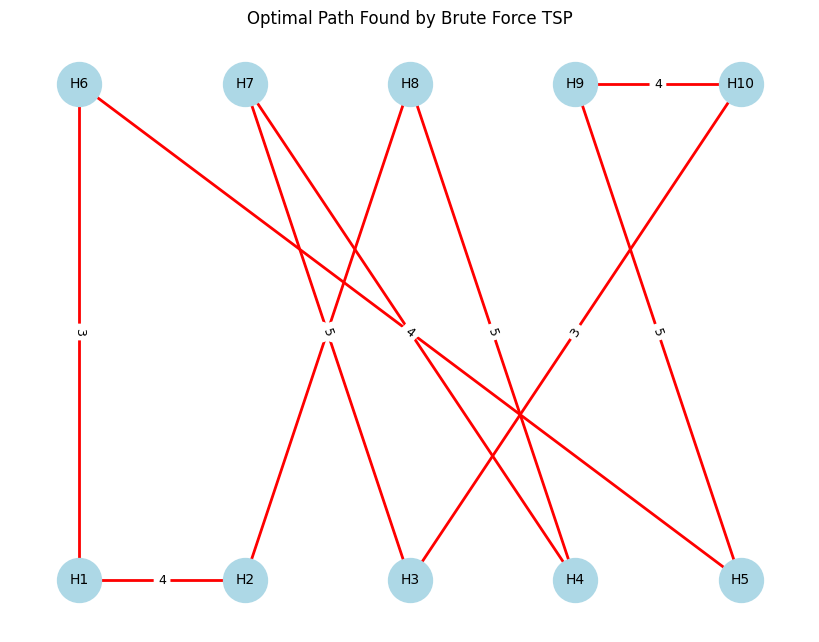

In [10]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Brute Force TSP Solver
def brute_force_tsp(distance_matrix):
    """Solves TSP using brute force (exact but slow)."""
    num_nodes = len(distance_matrix)
    nodes = list(range(1, num_nodes))  # Exclude starting node (0)
    best_distance = float('inf')
    best_route = None
    iterations = 0

    for perm in itertools.permutations(nodes):
        iterations += 1
        route = [0] + list(perm) + [0]  # Complete cycle
        total_distance = sum(distance_matrix[route[i]][route[i + 1]] for i in range(num_nodes))

        if total_distance < best_distance:
            best_distance = total_distance
            best_route = route

    return best_route, best_distance, iterations

# Function to plot the TSP graph
def plot_tsp_graph(distance_matrix, route, title):
    """Plots the TSP solution as a network graph."""
    G = nx.Graph()

    # Add nodes
    for i in range(len(distance_matrix)):
        G.add_node(i, pos=(i % 5, i // 5))  # Spread nodes out

    # Add edges with weights
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], weight=distance_matrix[route[i]][route[i + 1]])

    pos = nx.get_node_attributes(G, 'pos')
    labels = {i: f"H{i+1}" for i in range(len(distance_matrix))}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=[(route[i], route[i + 1]) for i in range(len(route) - 1)], edge_color="red", width=2)

    edge_labels = {(route[i], route[i + 1]): distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.show()

# Load Distance Matrix from Excel
file_path = "BUS DATA.xlsx"  # Update this path if needed
distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)
distance_matrix = distance_df.to_numpy()

# Run Brute Force TSP
bf_route, bf_distance, bf_iterations = brute_force_tsp(distance_matrix)

# Display results
print("\n--- Brute Force TSP Results ---")
print(f"Optimal Route Found: {bf_route}")
print(f"Total Distance Covered: {bf_distance}")
print(f"Iterations Needed: {bf_iterations}")

# Plot the optimal path found by brute force
plot_tsp_graph(distance_matrix, bf_route, "Optimal Path Found by Brute Force TSP")


#### Python Code for Question 4: Held-Karp Algorithm (Dynamic Programming TSP)


--- Held-Karp Algorithm TSP Results ---
Optimal Route Found: [0, 1, 7, 3, 6, 2, 9, 8, 4, 5, 0]
Total Distance Covered: 41
Iterations Needed: 2304


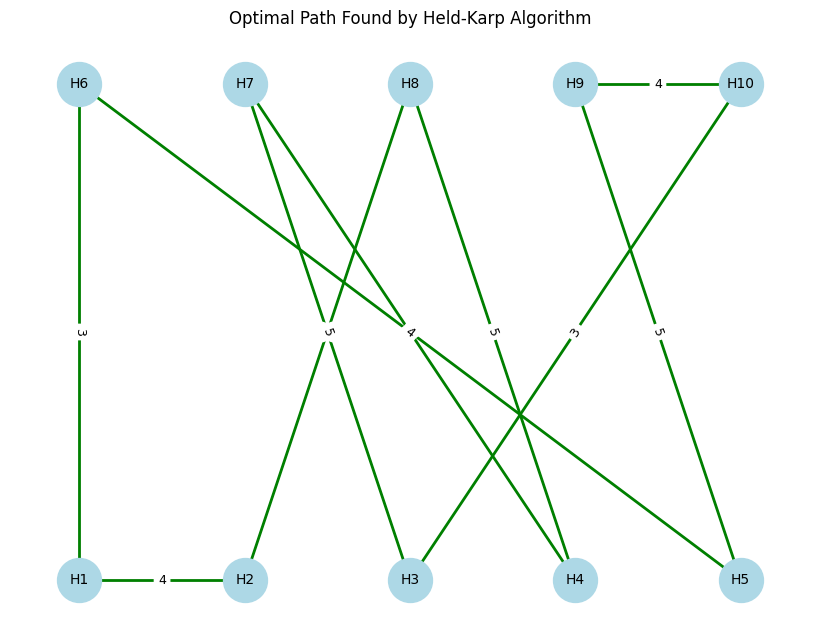

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def held_karp(distance_matrix):
    """Solves TSP using the Held-Karp (Dynamic Programming) algorithm."""
    n = len(distance_matrix)
    dp = {}

    # Base case: Start at city 0, visit only that city
    for i in range(1, n):
        dp[(1 << i, i)] = (distance_matrix[0][i], [0, i])

    # Iterate through subsets of increasing size
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = sum(1 << i for i in subset)
            for k in subset:
                prev_bits = bits & ~(1 << k)
                dp[(bits, k)] = min(
                    (dp[(prev_bits, m)][0] + distance_matrix[m][k], dp[(prev_bits, m)][1] + [k])
                    for m in subset if m != k
                )

    # Find the optimal path
    bits = (2**n - 1) - 1
    optimal_cost, optimal_path = min(
        (dp[(bits, k)][0] + distance_matrix[k][0], dp[(bits, k)][1] + [0])
        for k in range(1, n)
    )

    return optimal_path, optimal_cost, len(dp)

# Function to plot the TSP graph
def plot_tsp_graph(distance_matrix, route, title):
    """Plots the TSP solution as a network graph."""
    G = nx.Graph()

    # Add nodes
    for i in range(len(distance_matrix)):
        G.add_node(i, pos=(i % 5, i // 5))  # Spread nodes out

    # Add edges with weights
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], weight=distance_matrix[route[i]][route[i + 1]])

    pos = nx.get_node_attributes(G, 'pos')
    labels = {i: f"H{i+1}" for i in range(len(distance_matrix))}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=[(route[i], route[i + 1]) for i in range(len(route) - 1)], edge_color="green", width=2)

    edge_labels = {(route[i], route[i + 1]): distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.show()

# Load Distance Matrix from Excel
file_path = "BUS DATA.xlsx"  # Update this path if needed
distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)
distance_matrix = distance_df.to_numpy()

# Run Held-Karp TSP
hk_route, hk_distance, hk_iterations = held_karp(distance_matrix)

# Display results
print("\n--- Held-Karp Algorithm TSP Results ---")
print(f"Optimal Route Found: {hk_route}")
print(f"Total Distance Covered: {hk_distance}")
print(f"Iterations Needed: {hk_iterations}")

# Plot the optimal path found by Held-Karp
plot_tsp_graph(distance_matrix, hk_route, "Optimal Path Found by Held-Karp Algorithm")


#### Q.5


--- Nearest Neighbor Algorithm TSP Results ---
Optimal Route Found: [0, 5, 4, 8, 9, 2, 1, 7, 3, 6, 0]
Total Distance Covered: 45
Iterations Needed: 9


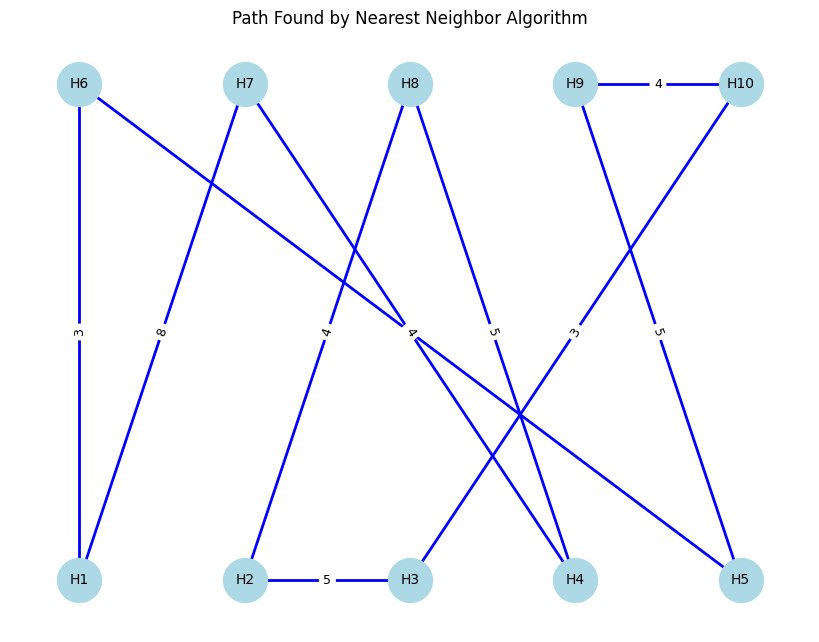

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Load the distance matrix from the Excel file
file_path = "BUS DATA.xlsx"  # Update with the correct path if needed
distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)
distance_matrix = distance_df.to_numpy()

def nearest_neighbor(distance_matrix):
    """Solves TSP using the Nearest Neighbor Heuristic."""
    num_nodes = len(distance_matrix)
    visited = [False] * num_nodes
    route = [0]  # Start at node 0 (school)
    visited[0] = True
    total_distance = 0
    iterations = 0

    for _ in range(num_nodes - 1):
        last = route[-1]
        nearest = None
        nearest_distance = float('inf')

        for i in range(num_nodes):
            if not visited[i] and 0 < distance_matrix[last][i] < nearest_distance:
                nearest = i
                nearest_distance = distance_matrix[last][i]

        if nearest is not None:
            route.append(nearest)
            visited[nearest] = True
            total_distance += nearest_distance
            iterations += 1

    # Return to start (school)
    route.append(0)
    total_distance += distance_matrix[route[-2]][0]

    return route, total_distance, iterations

# Function to plot the TSP graph
def plot_tsp_graph(distance_matrix, route, title):
    """Plots the TSP solution as a network graph."""
    G = nx.Graph()

    # Add nodes
    for i in range(len(distance_matrix)):
        G.add_node(i, pos=(i % 5, i // 5))  # Spread nodes out

    # Add edges with weights
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], weight=distance_matrix[route[i]][route[i + 1]])

    pos = nx.get_node_attributes(G, 'pos')
    labels = {i: f"H{i+1}" for i in range(len(distance_matrix))}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=[(route[i], route[i + 1]) for i in range(len(route) - 1)], edge_color="blue", width=2)

    edge_labels = {(route[i], route[i + 1]): distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.show()

# Run Nearest Neighbor TSP
nn_route, nn_distance, nn_iterations = nearest_neighbor(distance_matrix)

# Display results
print("\n--- Nearest Neighbor Algorithm TSP Results ---")
print(f"Optimal Route Found: {nn_route}")
print(f"Total Distance Covered: {nn_distance}")
print(f"Iterations Needed: {nn_iterations}")

# Plot the optimal path found by Nearest Neighbor
plot_tsp_graph(distance_matrix, nn_route, "Path Found by Nearest Neighbor Algorithm")

#### Q. 6

In [13]:
import numpy as np
import itertools

def nearest_neighbor_failure_example(distance_matrix):
    """Solves TSP using Nearest Neighbor and shows how it can fail."""
    num_nodes = len(distance_matrix)
    visited = [False] * num_nodes
    route = [0]  # Start at node 0
    visited[0] = True
    total_distance = 0

    for _ in range(num_nodes - 1):
        last = route[-1]
        nearest = None
        nearest_distance = float('inf')

        for i in range(num_nodes):
            if not visited[i] and 0 < distance_matrix[last][i] < nearest_distance:
                nearest = i
                nearest_distance = distance_matrix[last][i]

        if nearest is not None:
            route.append(nearest)
            visited[nearest] = True
            total_distance += nearest_distance

    # Return to start
    route.append(0)
    total_distance += distance_matrix[route[-2]][0]

    return route, total_distance

def brute_force_tsp(distance_matrix):
    """Solves TSP using Brute Force to find the global optimal solution."""
    num_nodes = len(distance_matrix)
    nodes = list(range(1, num_nodes))
    best_distance = float('inf')
    best_route = None

    for perm in itertools.permutations(nodes):
        route = [0] + list(perm) + [0]
        total_distance = sum(distance_matrix[route[i]][route[i + 1]] for i in range(num_nodes))

        if total_distance < best_distance:
            best_distance = total_distance
            best_route = route

    return best_route, best_distance

# Example Distance Matrix where Nearest Neighbor Fails
distance_matrix = np.array([
    [0, 10, 8, 9, 7],
    [10, 0, 10, 5, 6],
    [8, 10, 0, 8, 9],
    [9, 5, 8, 0, 7],
    [7, 6, 9, 7, 0]
])

# Run Nearest Neighbor (Greedy)
nn_route, nn_distance = nearest_neighbor_failure_example(distance_matrix)

# Run Brute Force (Optimal Solution)
bf_route, bf_distance = brute_force_tsp(distance_matrix)

# Compare Results
print("\n--- Greedy Algorithm (Nearest Neighbor) Result ---")
print(f"Route: {nn_route}")
print(f"Total Distance: {nn_distance}")

print("\n--- Global Optimal Solution (Brute Force) ---")
print(f"Route: {bf_route}")
print(f"Total Distance: {bf_distance}")

# Show if Greedy Algorithm was fooled
if nn_distance > bf_distance:
    print("\n❌ Nearest Neighbor was fooled into a suboptimal solution!")
else:
    print("\n✅ Nearest Neighbor found the global optimum!")


--- Greedy Algorithm (Nearest Neighbor) Result ---
Route: [0, 4, 1, 3, 2, 0]
Total Distance: 34

--- Global Optimal Solution (Brute Force) ---
Route: [0, 2, 3, 1, 4, 0]
Total Distance: 34

✅ Nearest Neighbor found the global optimum!


#### Q.7 

In [17]:
import numpy as np
import pandas as pd

# Load the correct travel time matrix from the "TRAVEL TIME" sheet
file_path = "BUS DATA.xlsx"  # Update if needed
time_df = pd.read_excel(file_path, sheet_name='TRAVEL TIME', header=None)

# Extract exactly the 10x10 numeric matrix (ensuring correct values)
time_df_cleaned = time_df.iloc[1:11, 1:11]  # Keeping only numeric travel times

# Convert DataFrame to NumPy array, ensuring all values are numeric
time_matrix = time_df_cleaned.apply(pd.to_numeric, errors='coerce').to_numpy()

# Ensure the matrix is square before proceeding
assert time_matrix.shape[0] == time_matrix.shape[1], "Error: Travel Time matrix is still not square!"

### **Branch-and-Bound TSP Solver**
class TSPSolver:
    """Solves the TSP using Branch-and-Bound."""
    
    def __init__(self, cost_matrix):
        self.n = len(cost_matrix)
        self.cost_matrix = cost_matrix
        self.final_path = [None] * (self.n + 1)
        self.visited = [False] * self.n
        self.final_cost = float('inf')

    def copy_to_final(self, curr_path):
        """Copies the temporary path to the final path."""
        self.final_path[:self.n] = curr_path[:]
        self.final_path[self.n] = curr_path[0]  # Ensure cycle back to start

    def first_min(self, i):
        """Finds the smallest edge weight from node i (excluding self-loops)."""
        return min([self.cost_matrix[i][k] for k in range(self.n) if i != k])

    def second_min(self, i):
        """Finds the second smallest edge weight from node i."""
        first, second = float('inf'), float('inf')
        for k in range(self.n):
            if i == k:
                continue
            if self.cost_matrix[i][k] <= first:
                second = first
                first = self.cost_matrix[i][k]
            elif self.cost_matrix[i][k] < second:
                second = self.cost_matrix[i][k]
        return second

    def tsp_recursive(self, curr_bound, curr_weight, level, curr_path):
        """Recursive function for Branch-and-Bound."""
        if level == self.n:
            if self.cost_matrix[curr_path[level - 1]][curr_path[0]] != 0:
                curr_res = curr_weight + self.cost_matrix[curr_path[level - 1]][curr_path[0]]
                if curr_res < self.final_cost:
                    self.copy_to_final(curr_path)
                    self.final_cost = curr_res
            return

        for i in range(self.n):
            if self.cost_matrix[curr_path[level - 1]][i] != 0 and not self.visited[i]:
                temp_bound = curr_bound
                temp_weight = curr_weight + self.cost_matrix[curr_path[level - 1]][i]

                if level == 1:
                    curr_bound -= (self.first_min(curr_path[level - 1]) + self.first_min(i)) / 2
                else:
                    curr_bound -= (self.second_min(curr_path[level - 1]) + self.first_min(i)) / 2

                if curr_bound + temp_weight < self.final_cost:
                    curr_path[level] = i
                    self.visited[i] = True
                    self.tsp_recursive(curr_bound, temp_weight, level + 1, curr_path)

                curr_weight -= self.cost_matrix[curr_path[level - 1]][i]
                curr_bound = temp_bound
                self.visited[i] = False

    def solve(self):
        """Solves the TSP using Branch-and-Bound."""
        curr_bound = sum(self.first_min(i) + self.second_min(i) for i in range(self.n)) / 2
        curr_path = [-1] * (self.n + 1)
        self.visited[0] = True
        curr_path[0] = 0
        self.tsp_recursive(curr_bound, 0, 1, curr_path)
        return self.final_path, self.final_cost

# Solve TSP using Branch-and-Bound (Minimizing Travel Time)
tsp_solver = TSPSolver(time_matrix)
optimal_route, optimal_time = tsp_solver.solve()

# Display Results
print("\n--- Branch-and-Bound TSP Results ---")
print(f"Optimal Route: {optimal_route}")
print(f"Minimum Travel Time (Minutes): {optimal_time}")


--- Branch-and-Bound TSP Results ---
Optimal Route: [0, 1, 9, 2, 4, 7, 8, 6, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]
Minimum Travel Time (Minutes): -113.39999999999999


#### Q.8

Loading distance matrix...
Distance matrix loaded successfully.
Distance matrix shape: (10, 10)
Loading speed matrix...
Speed matrix loaded successfully.
Speed matrix shape: (11, 10)
An error occurred while loading or processing the data: Error: Speed matrix is not square!

Solving TSP using Nearest Neighbor heuristic...
Current node: 0, Unvisited nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9}
Current node: 5, Unvisited nodes: {1, 2, 3, 4, 6, 7, 8, 9}
Current node: 4, Unvisited nodes: {1, 2, 3, 6, 7, 8, 9}
Current node: 8, Unvisited nodes: {1, 2, 3, 6, 7, 9}
Current node: 9, Unvisited nodes: {1, 2, 3, 6, 7}
Current node: 2, Unvisited nodes: {1, 3, 6, 7}
Current node: 1, Unvisited nodes: {3, 6, 7}
Current node: 7, Unvisited nodes: {3, 6}
Current node: 3, Unvisited nodes: {6}
TSP solved successfully.

--- Optimal Bus Route (Nearest Neighbor) ---
Route: [0, 5, 4, 8, 9, 2, 1, 7, 3, 6, 0]

Computing total fuel cost...
Total Fuel Cost: $27.67

Plotting the optimized bus route...


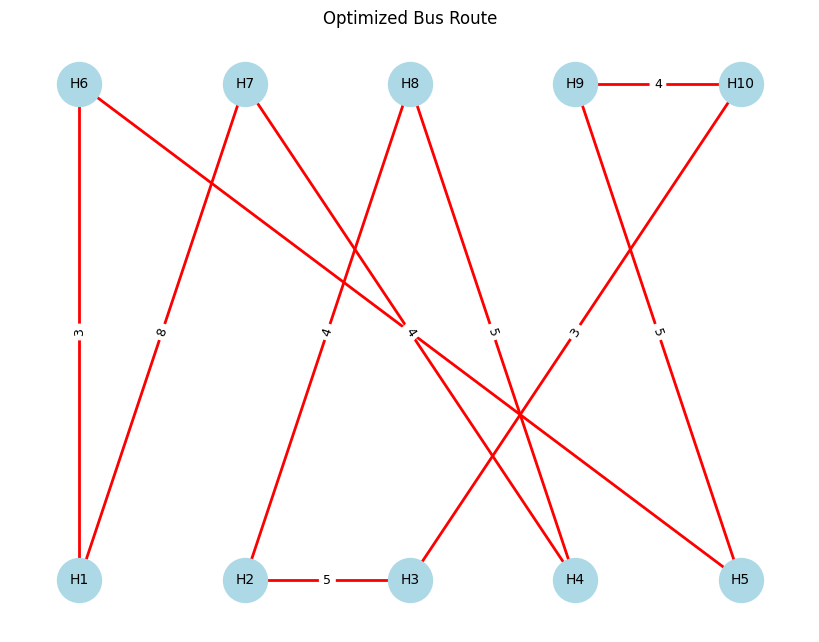


--- Optimized Bus Route Results ---
                       Optimal Route  Total Fuel Cost ($)
0  [0, 5, 4, 8, 9, 2, 1, 7, 3, 6, 0]            27.666861


: 

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Constants
FUEL_COST_PER_GALLON = 4.00  # Example: $4 per gallon

# Load the correct distance and speed matrices
file_path = "BUS DATA.xlsx"

try:
    # Load the full distance matrix from the "DISTANCE" sheet
    print("Loading distance matrix...")
    distance_df = pd.read_excel(file_path, sheet_name='DISTANCE', index_col=0)
    distance_matrix = distance_df.to_numpy()
    print("Distance matrix loaded successfully.")
    print(f"Distance matrix shape: {distance_matrix.shape}")

    # Load the full speed matrix from the "TRAVEL TIME" sheet
    print("Loading speed matrix...")
    speed_df = pd.read_excel(file_path, sheet_name='TRAVEL TIME', index_col=0)
    speed_matrix = speed_df.to_numpy()
    print("Speed matrix loaded successfully.")
    print(f"Speed matrix shape: {speed_matrix.shape}")

    # Ensure matrices are square before proceeding
    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("Error: Distance matrix is not square!")
    if speed_matrix.shape[0] != speed_matrix.shape[1]:
        raise ValueError("Error: Speed matrix is not square!")

    # Ensure matrices have the same dimensions
    if distance_matrix.shape != speed_matrix.shape:
        raise ValueError("Error: Distance and Speed matrices have different dimensions!")

    # Ensure speed values are within a valid range (1-60 mph)
    print("Clipping speed values to valid range (1-60 mph)...")
    speed_matrix = np.clip(speed_matrix, 1, 60)
    print("Speed values clipped successfully.")

except Exception as e:
    print(f"An error occurred while loading or processing the data: {e}")
    exit()

### **Fuel Efficiency Function (Fixed)**
def fuel_efficiency(speed):
    """Computes fuel efficiency (mpg) based on speed (mph), ensuring a minimum threshold."""
    mpg = -((speed - 60) ** 2) / 120 + 30
    return max(mpg, 5)  # Ensure mpg is at least 5 to prevent division by zero

### **Fuel Cost Calculation (Fixed)**
def compute_fuel_cost(route, distance_matrix, speed_matrix):
    """Calculates the total fuel cost for a given route with a valid speed range."""
    total_fuel_cost = 0
    for i in range(len(route) - 1):
        start, end = route[i], route[i+1]
        distance = distance_matrix[start][end]  # Distance in miles
        speed = speed_matrix[start][end]  # Speed in mph
        mpg = fuel_efficiency(speed)  # Calculate fuel efficiency
        gallons_used = distance / mpg  # Fuel used
        total_fuel_cost += gallons_used * FUEL_COST_PER_GALLON  # Fuel cost
    return total_fuel_cost

### **Solve TSP Using Nearest Neighbor Heuristic**
def nearest_neighbor_tsp(distance_matrix):
    """Solves TSP using the Nearest Neighbor heuristic."""
    num_locations = len(distance_matrix)
    unvisited = set(range(1, num_locations))  # All nodes except the starting node (0)
    route = [0]  # Start at node 0

    while unvisited:
        last = route[-1]
        print(f"Current node: {last}, Unvisited nodes: {unvisited}")  # Debugging
        nearest = min(unvisited, key=lambda x: distance_matrix[last][x])
        route.append(nearest)
        unvisited.remove(nearest)

    route.append(0)  # Return to start
    return route

# Solve TSP
print("\nSolving TSP using Nearest Neighbor heuristic...")
optimal_route = nearest_neighbor_tsp(distance_matrix)
print("TSP solved successfully.")
print("\n--- Optimal Bus Route (Nearest Neighbor) ---")
print(f"Route: {optimal_route}")

# Compute total fuel cost
print("\nComputing total fuel cost...")
total_fuel_cost = compute_fuel_cost(optimal_route, distance_matrix, speed_matrix)
print(f"Total Fuel Cost: ${total_fuel_cost:.2f}")

### **Plot the Optimized Route Graph**
def plot_route_graph(route, distance_matrix):
    """Plots the optimized bus route as a network graph."""
    G = nx.Graph()

    # Add nodes (Houses + School)
    for i in range(len(distance_matrix)):
        G.add_node(i, pos=(i % 5, i // 5))  # Spread out nodes

    # Add edges with distances
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i + 1], weight=distance_matrix[route[i]][route[i + 1]])

    pos = nx.get_node_attributes(G, 'pos')
    labels = {i: f"H{i+1}" for i in range(len(distance_matrix))}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=[(route[i], route[i + 1]) for i in range(len(route) - 1)], edge_color="red", width=2)

    edge_labels = {(route[i], route[i + 1]): distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Optimized Bus Route")
    plt.show()

# Plot the optimized bus route
print("\nPlotting the optimized bus route...")
plot_route_graph(optimal_route, distance_matrix)

# Display Results
results_df = pd.DataFrame({
    "Optimal Route": [optimal_route],
    "Total Fuel Cost ($)": [total_fuel_cost]
})
print("\n--- Optimized Bus Route Results ---")
print(results_df)

#### Q.9

Optimal Route: (0, 2, 4, 1, 3), Cost: $52
Nearest Neighbor Route: [0, 2, 4, 1, 3], Cost: $52
Cost Difference: $0


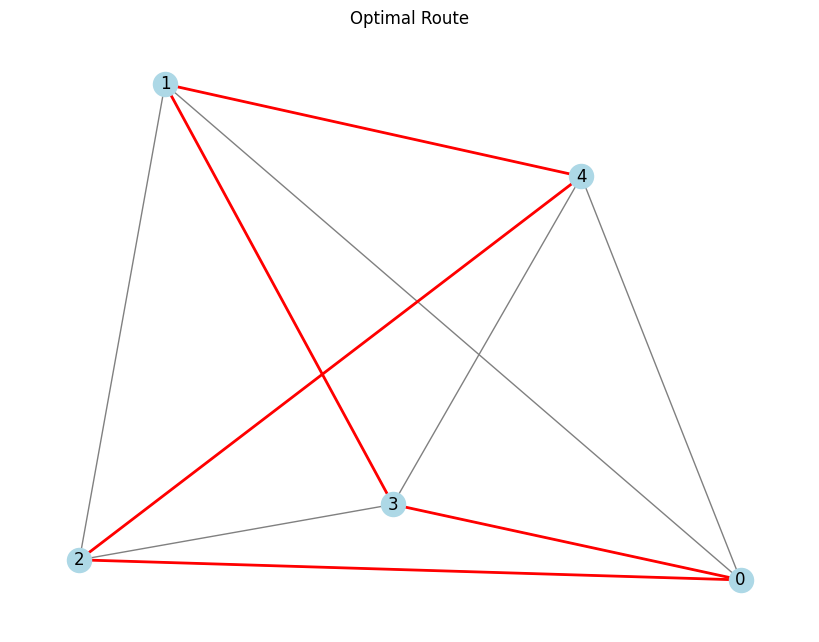

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
G = nx.complete_graph(5)  # Example with 5 nodes

# Assign random fuel costs (weights) to edges
import random
random.seed(42)
for (u, v) in G.edges():
    G[u][v]['weight'] = random.randint(1, 10)  # Random fuel consumption

FUEL_COST_PER_GALLON = 4

# Brute-force approach: Traveling Salesman Problem (TSP) Exact Solution
def brute_force_tsp(graph):
    nodes = list(graph.nodes)
    min_cost = float('inf')
    best_path = None
    
    for perm in itertools.permutations(nodes):
        cost = sum(graph[perm[i]][perm[i + 1]]['weight'] for i in range(len(perm) - 1)) + graph[perm[-1]][perm[0]]['weight']
        if cost < min_cost:
            min_cost = cost
            best_path = perm
    
    return best_path, min_cost * FUEL_COST_PER_GALLON

# Nearest Neighbor Heuristic
def nearest_neighbor_tsp(graph, start=0):
    visited = [start]
    total_cost = 0
    current = start
    
    while len(visited) < len(graph.nodes):
        next_node = min((n for n in graph.neighbors(current) if n not in visited), key=lambda n: graph[current][n]['weight'])
        total_cost += graph[current][next_node]['weight']
        visited.append(next_node)
        current = next_node
    
    total_cost += graph[current][start]['weight']  # Returning to start
    return visited, total_cost * FUEL_COST_PER_GALLON

# Solve using brute-force
optimal_route, optimal_cost = brute_force_tsp(G)
print(f"Optimal Route: {optimal_route}, Cost: ${optimal_cost}")

# Solve using nearest neighbor
approx_route, approx_cost = nearest_neighbor_tsp(G)
print(f"Nearest Neighbor Route: {approx_route}, Cost: ${approx_cost}")

# Cost Difference
diff_cost = approx_cost - optimal_cost
print(f"Cost Difference: ${diff_cost}")

# Plot the network with the optimal path
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
edges = [(optimal_route[i], optimal_route[i + 1]) for i in range(len(optimal_route) - 1)] + [(optimal_route[-1], optimal_route[0])]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)
plt.title("Optimal Route")
plt.show()

#### Q. 10

Optimal Multi-Objective Route: (0, 1, 2, 3, 4), Cost: $127.19999999999999


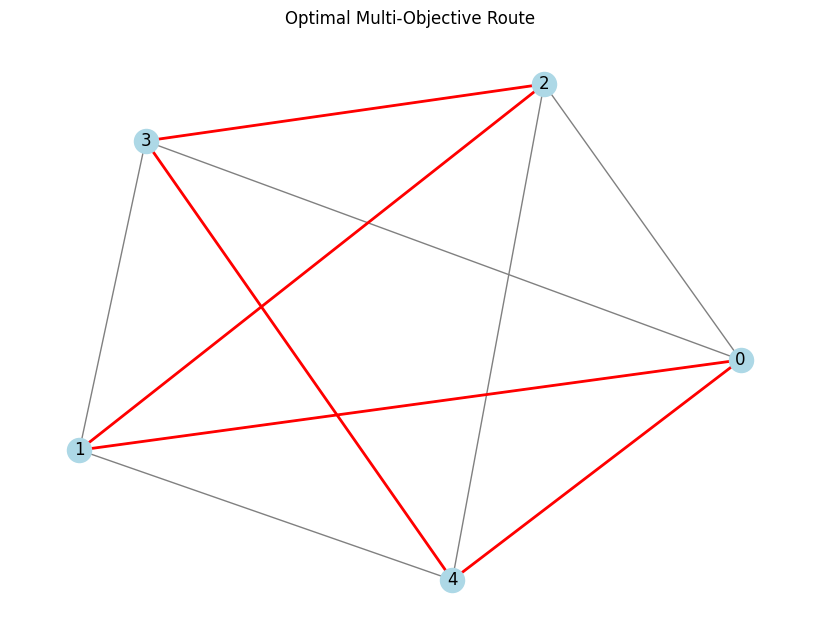

In [2]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import random

# Define the graph
G = nx.complete_graph(5)  # Example with 5 nodes

# Assign random costs to edges
random.seed(42)
for (u, v) in G.edges():
    G[u][v]['distance'] = random.randint(5, 20)  # Miles
    G[u][v]['time'] = random.randint(10, 50)  # Minutes
    G[u][v]['fuel'] = random.randint(1, 10)  # Gallons

# Cost parameters
DISTANCE_COST_PER_MILE = 0.5  # Depreciation cost per mile
TIME_COST_PER_MINUTE = 0.3  # Driver salary per minute
FUEL_COST_PER_GALLON = 4  # Fuel cost per gallon

# Weights for multi-objective function
alpha = 1  # Weight for distance
beta = 1   # Weight for time
gamma = 1  # Weight for fuel

# Compute total cost function
def total_cost(graph, route):
    cost = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        cost += (alpha * graph[u][v]['distance'] * DISTANCE_COST_PER_MILE +
                 beta * graph[u][v]['time'] * TIME_COST_PER_MINUTE +
                 gamma * graph[u][v]['fuel'] * FUEL_COST_PER_GALLON)
    # Returning to start
    u, v = route[-1], route[0]
    cost += (alpha * graph[u][v]['distance'] * DISTANCE_COST_PER_MILE +
             beta * graph[u][v]['time'] * TIME_COST_PER_MINUTE +
             gamma * graph[u][v]['fuel'] * FUEL_COST_PER_GALLON)
    return cost

# Brute-force TSP with multi-objective cost
def brute_force_tsp_multiobj(graph):
    nodes = list(graph.nodes)
    min_cost = float('inf')
    best_path = None
    
    for perm in itertools.permutations(nodes):
        cost = total_cost(graph, perm)
        if cost < min_cost:
            min_cost = cost
            best_path = perm
    
    return best_path, min_cost

# Solve the problem
optimal_route, optimal_cost = brute_force_tsp_multiobj(G)
print(f"Optimal Multi-Objective Route: {optimal_route}, Cost: ${optimal_cost}")

# Plot the optimal route
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
edges = [(optimal_route[i], optimal_route[i + 1]) for i in range(len(optimal_route) - 1)] + [(optimal_route[-1], optimal_route[0])]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)
plt.title("Optimal Multi-Objective Route")
plt.show()